In [5]:
# ==============================================================================
# Bloco 0: Configuração Inicial
# ==============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
print("--- Ambiente Configurado ---")

--- Ambiente Configurado ---


In [7]:
# ==============================================================================
# Bloco 1: Carregamento e Inspeção Inicial
# ==============================================================================
print("\n--- Bloco 1: Carregando os Arquivos ---")
try:
    df_variaveis = pd.read_excel('lista_variaveis.xlsx')
    df_treino = pd.read_csv('dados_projeto_evasao_treino.csv')
    df_teste = pd.read_csv('dados_projeto_evasao_teste.csv')
    print("✅ Arquivos carregados com sucesso!")
except Exception as e:
    print(f"❌ Ocorreu um erro inesperado: {e}")


--- Bloco 1: Carregando os Arquivos ---
✅ Arquivos carregados com sucesso!


In [8]:
# ==============================================================================
# Bloco 2 e 3: Limpeza de Colunas com Muitos Dados Ausentes
# ==============================================================================
print("\n--- Bloco 2 & 3: Limpando Colunas com Dados Muito Ausentes ---")

if 'df_treino' in locals():
    LIMIAR_PARA_REMOVER = 70.0
    missing_percentage = (df_treino.isnull().sum() / len(df_treino)) * 100
    colunas_para_remover_ausentes = missing_percentage[missing_percentage > LIMIAR_PARA_REMOVER].index.tolist()

    if colunas_para_remover_ausentes:
        print(f"As seguintes colunas serão REMOVIDAS por terem mais de {LIMIAR_PARA_REMOVER}% de dados ausentes:")
        for col in colunas_para_remover_ausentes:
            print(f"- {col} ({missing_percentage[col]:.2f}%)")

        df_treino_limpo = df_treino.drop(columns=colunas_para_remover_ausentes)
        df_teste_limpo = df_teste.drop(columns=colunas_para_remover_ausentes)
        print("\n✅ Colunas com alta ausência de dados removidas.")
    else:
        print("Nenhuma coluna ultrapassou o limiar de remoção.")
        df_treino_limpo = df_treino.copy()
        df_teste_limpo = df_teste.copy()
else:
    print("ERRO: DataFrame 'df_treino' não foi carregado.")


--- Bloco 2 & 3: Limpando Colunas com Dados Muito Ausentes ---
As seguintes colunas serão REMOVIDAS por terem mais de 70.0% de dados ausentes:
- vl_medio_tempo_questionario (72.25%)
- vl_medio_tempo_questionario_avaliado (73.25%)
- vl_desempenho_questionario (93.25%)
- vl_engajamento_usuario_por_intervalo (92.75%)
- vl_engajamento_usuario_intradia (92.75%)
- vl_desempenho_usuario (71.75%)
- vl_media_questoes_por_dia (84.75%)
- vl_engajamento_notas (84.75%)
- vl_media_notas (71.75%)
- vl_media_submissoes_codigo (99.00%)
- vl_submissoes_por_dias_ativos (98.00%)

✅ Colunas com alta ausência de dados removidas.



--- Bloco 4: Criando a Variável-Alvo e Fazendo a Limpeza Final ---
✅ Coluna 'target_evadiu' criada com sucesso (limiar: 30 dias).

Análise da Nova Variável Alvo ('target_evadiu'):
target_evadiu
1    60.0
0    40.0
Name: proportion, dtype: float64


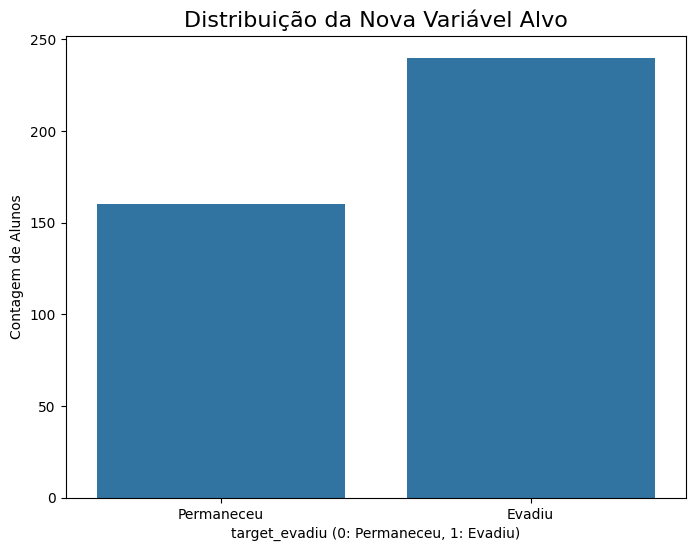


Verificando e removendo colunas de ID, data e 'leakage'...
Colunas efetivamente removidas do treino: ['ts_primeiro_acesso', 'ts_ultimo_acesso', 'nr_dias_desde_ultimo_acesso']

✅ Colunas de ID, data e 'leakage' removidas.

--- Resumo Final da Preparação ---
Formato final do df_treino_final: (400, 24)
Formato final do df_teste_final: (100, 24)

✅ Dataframes 'df_treino_final' e 'df_teste_final' estão prontos para a próxima fase!


In [9]:
# ==============================================================================
# Bloco 4: Engenharia da Variável-Alvo e Limpeza Final (VERSÃO CORRIGIDA)
# ==============================================================================
print("\n--- Bloco 4: Criando a Variável-Alvo e Fazendo a Limpeza Final ---")

if 'df_treino_limpo' in locals():
    # --- 4.1: Engenharia da Variável-Alvo ---
    DIAS_PARA_EVASAO = 30
    df_treino_limpo['target_evadiu'] = (df_treino_limpo['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
    df_teste_limpo['target_evadiu'] = (df_teste_limpo['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
    print(f"✅ Coluna 'target_evadiu' criada com sucesso (limiar: {DIAS_PARA_EVASAO} dias).")

    # --- 4.2: Análise da Nova Variável-Alvo ---
    print("\nAnálise da Nova Variável Alvo ('target_evadiu'):")
    print(df_treino_limpo['target_evadiu'].value_counts(normalize=True).round(4) * 100)
    
    plt.figure(figsize=(8, 6))
    sns.countplot(x='target_evadiu', data=df_treino_limpo)
    plt.title('Distribuição da Nova Variável Alvo', fontsize=16)
    plt.ylabel('Contagem de Alunos')
    plt.xlabel('target_evadiu (0: Permaneceu, 1: Evadiu)')
    plt.xticks([0, 1], ['Permaneceu', 'Evadiu'])
    plt.show()

    # --- 4.3: Limpeza Final de Colunas (IDs e Vazamento de Dados) ---
    colunas_para_remover_final = [
        'id_usuario',                      
        'ts_primeiro_acesso',              
        'ts_ultimo_acesso',                
        'nr_dias_desde_ultimo_acesso'      
    ]
    
    # ***** INÍCIO DA CORREÇÃO *****
    # Antes de remover, vamos verificar quais colunas da lista realmente existem nos dataframes
    colunas_a_remover_treino = [col for col in colunas_para_remover_final if col in df_treino_limpo.columns]
    colunas_a_remover_teste = [col for col in colunas_para_remover_final if col in df_teste_limpo.columns]
    
    print("\nVerificando e removendo colunas de ID, data e 'leakage'...")
    print(f"Colunas efetivamente removidas do treino: {colunas_a_remover_treino}")
    
    # Agora removemos apenas as colunas que foram encontradas
    df_treino_final = df_treino_limpo.drop(columns=colunas_a_remover_treino)
    df_teste_final = df_teste_limpo.drop(columns=colunas_a_remover_teste)
    # ***** FIM DA CORREÇÃO *****
    
    print("\n✅ Colunas de ID, data e 'leakage' removidas.")
    
    print("\n--- Resumo Final da Preparação ---")
    print(f"Formato final do df_treino_final: {df_treino_final.shape}")
    print(f"Formato final do df_teste_final: {df_teste_final.shape}")
    print("\n✅ Dataframes 'df_treino_final' e 'df_teste_final' estão prontos para a próxima fase!")
    
else:
    print("ERRO: DataFrame 'df_treino_limpo' não foi criado. O processo não pode continuar.")

--- Bloco 5: Iniciando a Análise Exploratória das Features Limpas ---
Encontramos 22 features numéricas e 1 features categóricas.


--- 5.2: Análise de Features Numéricas vs. Evasão ---


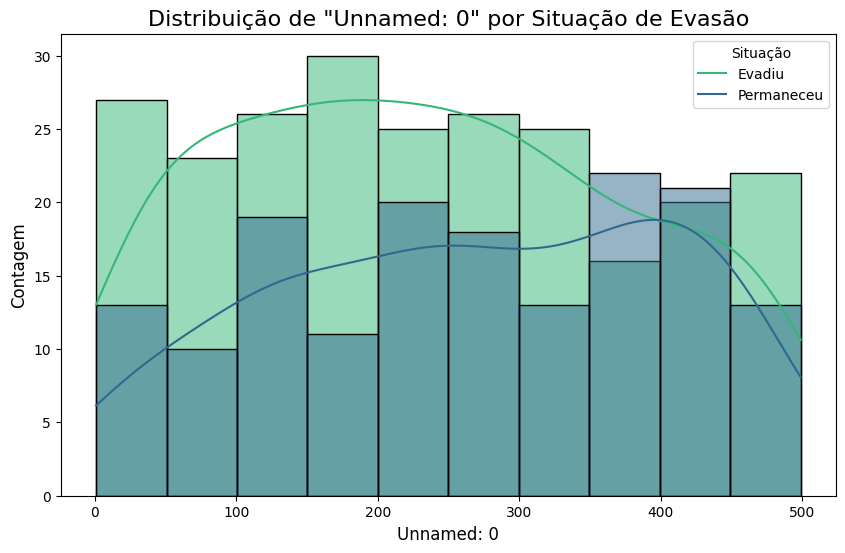

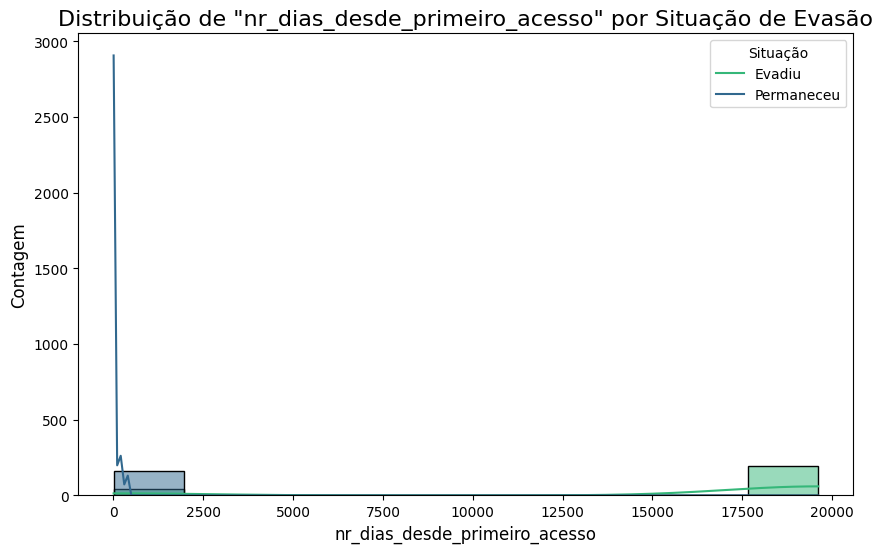

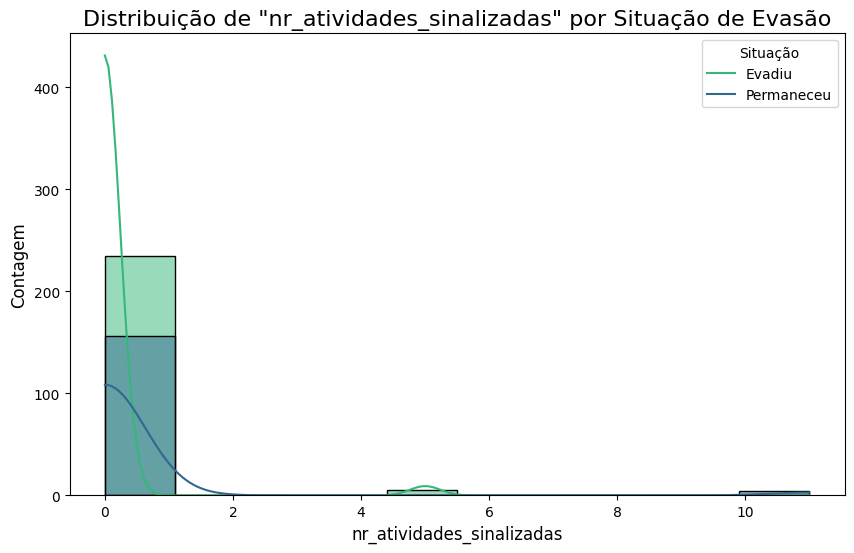

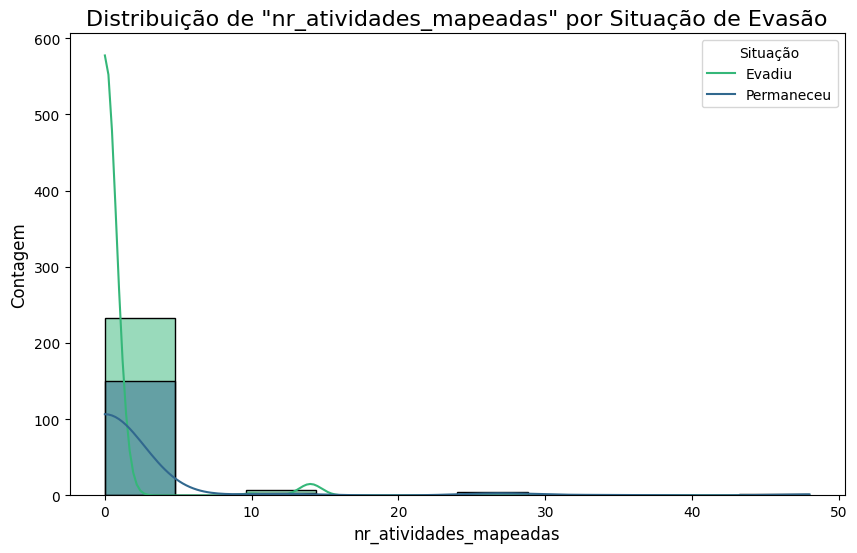

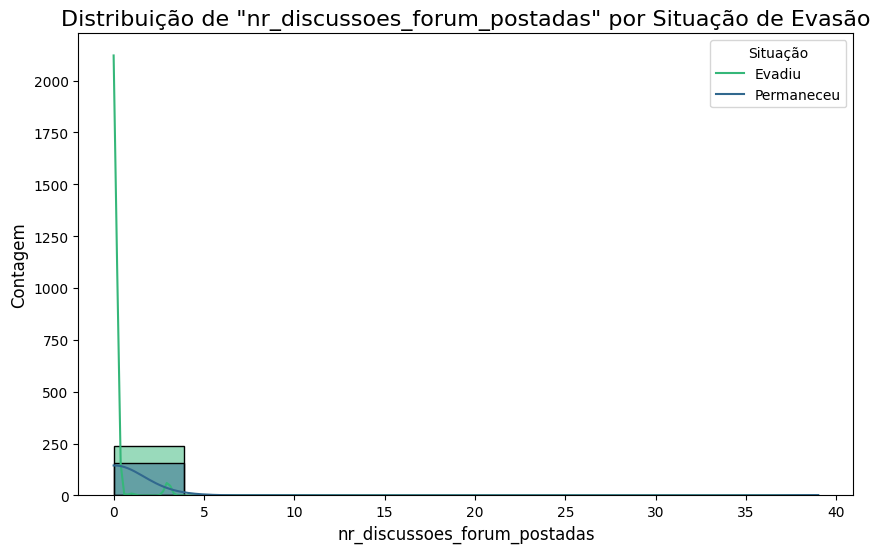

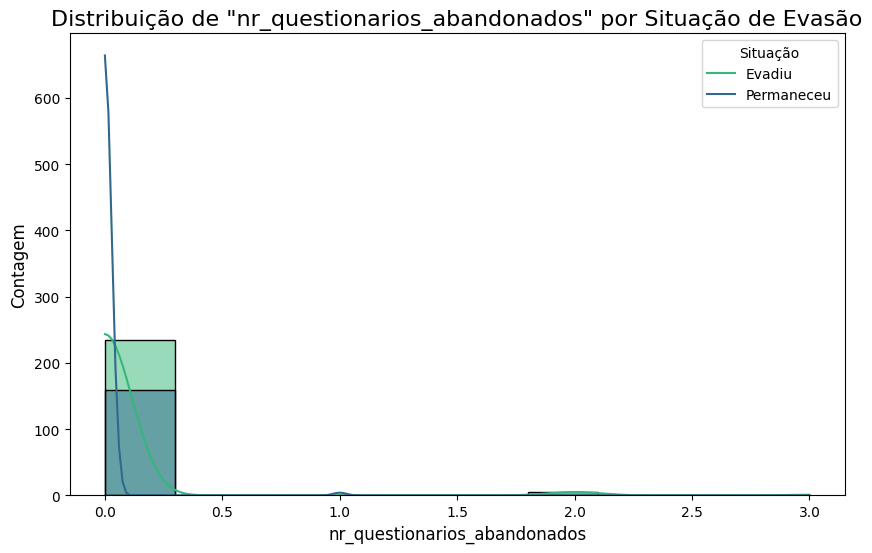

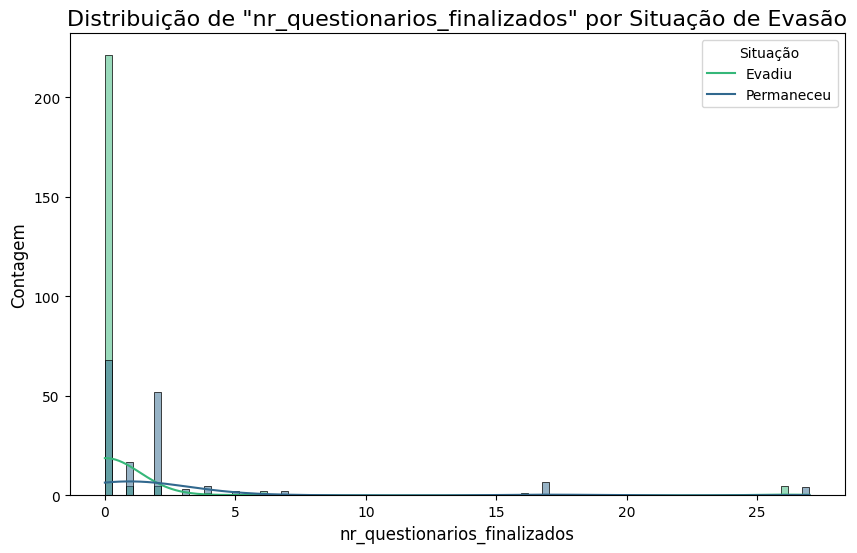

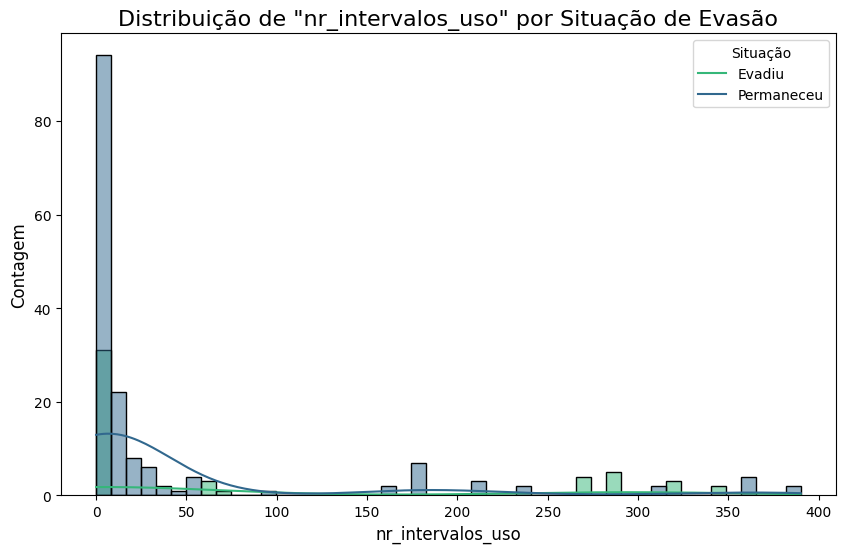

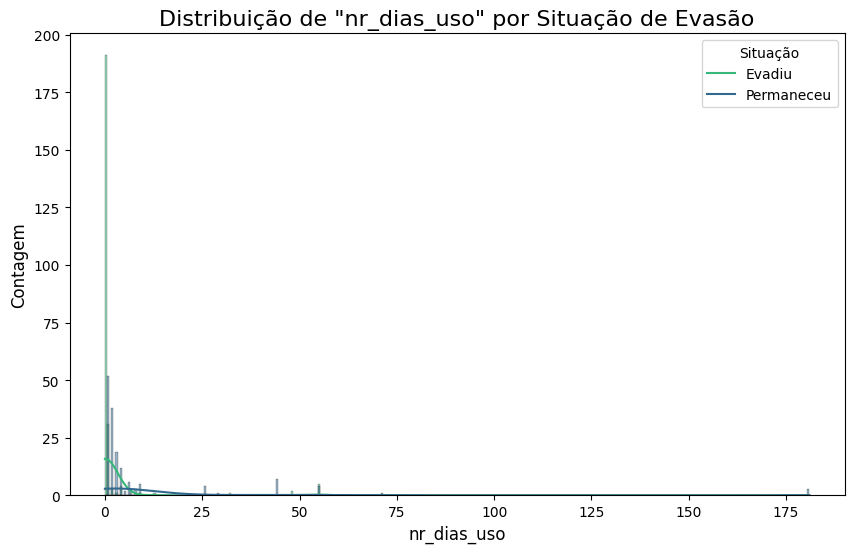

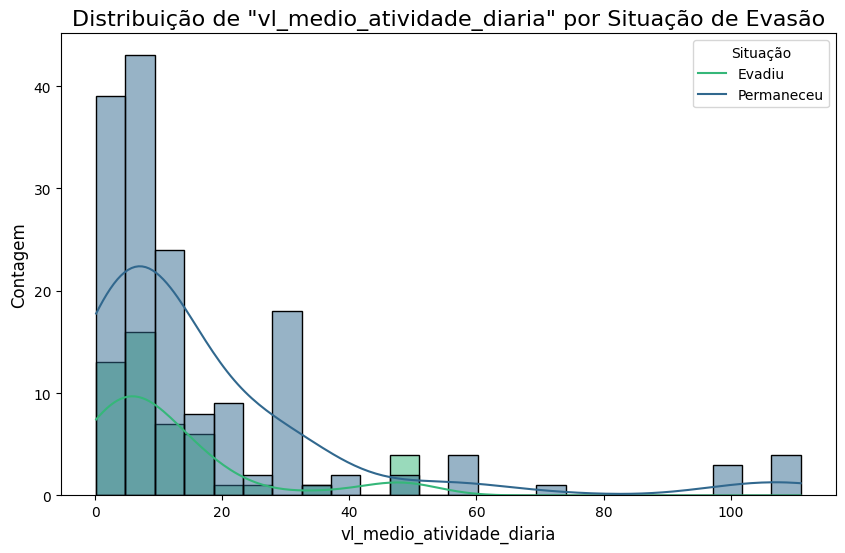

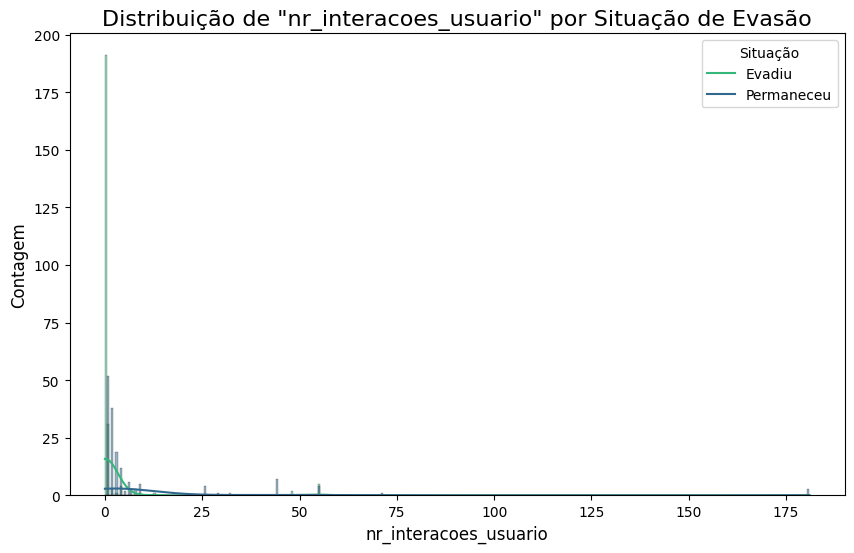

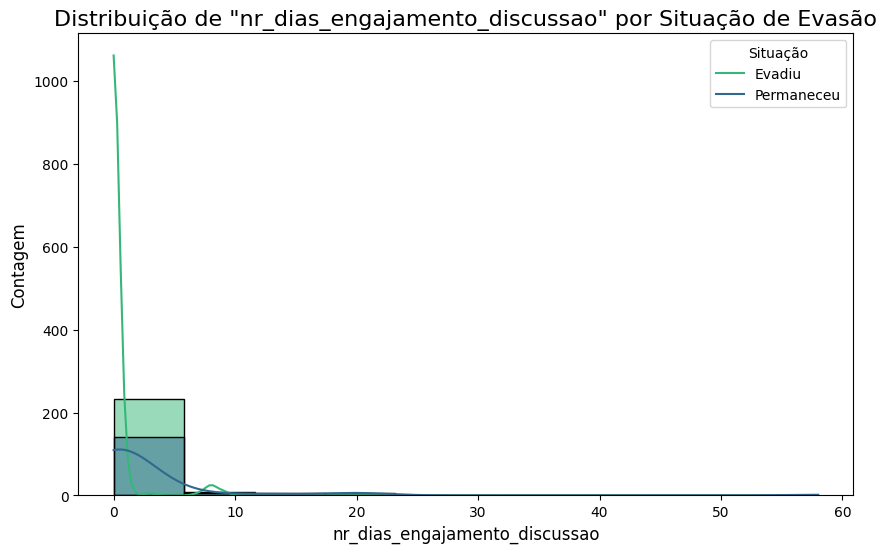

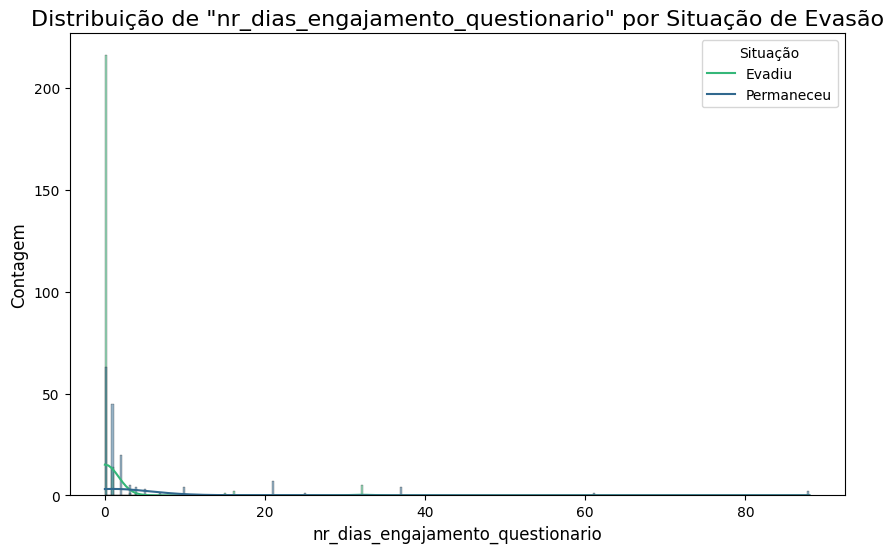

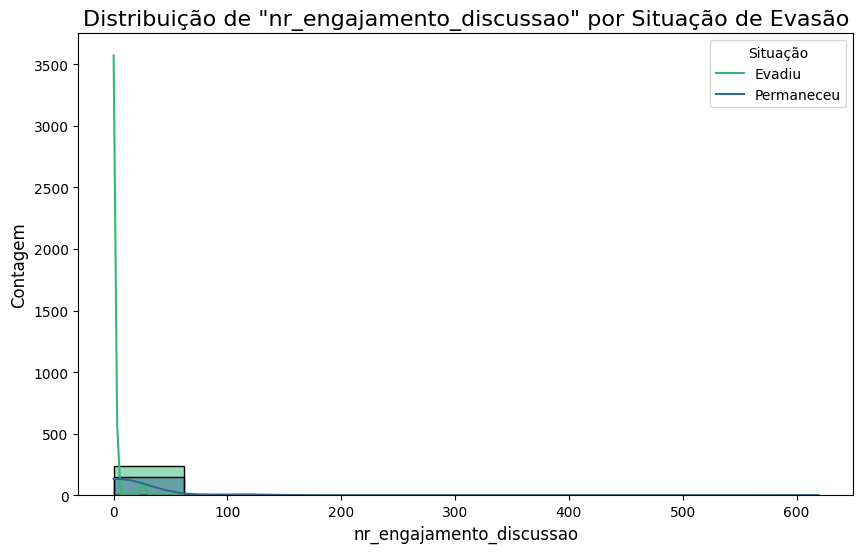

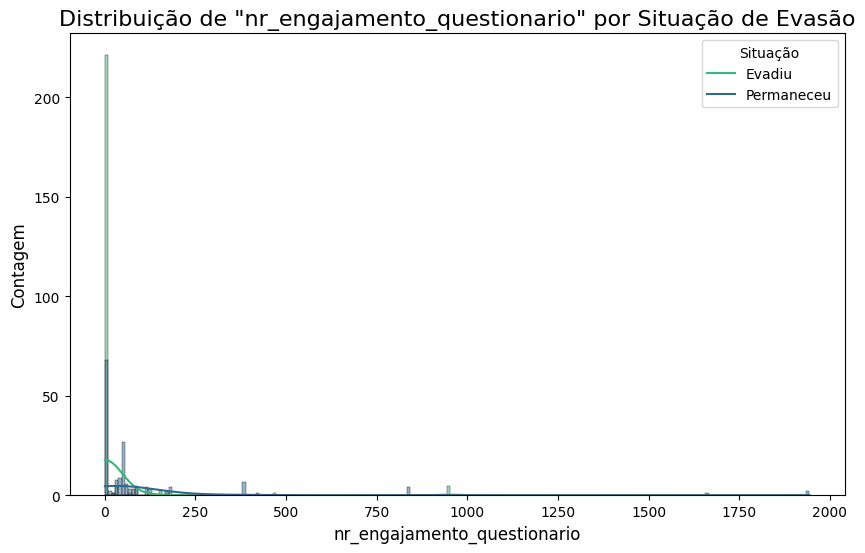

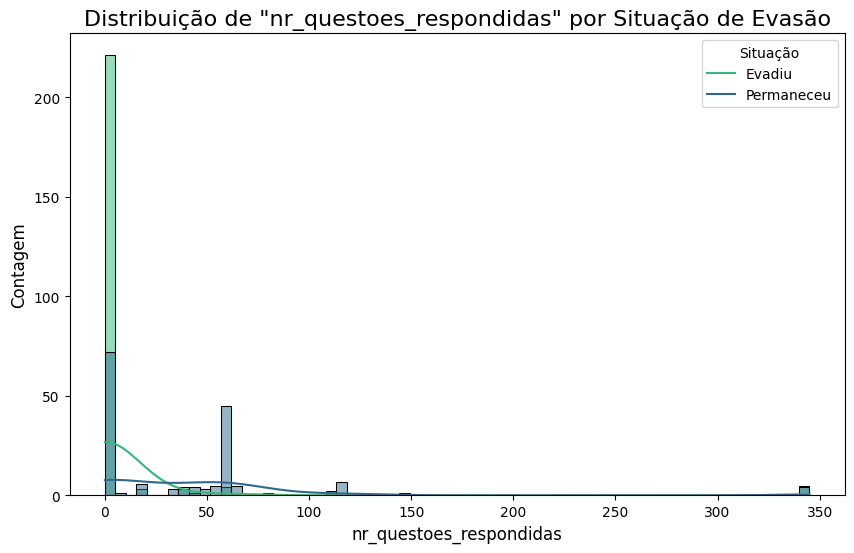

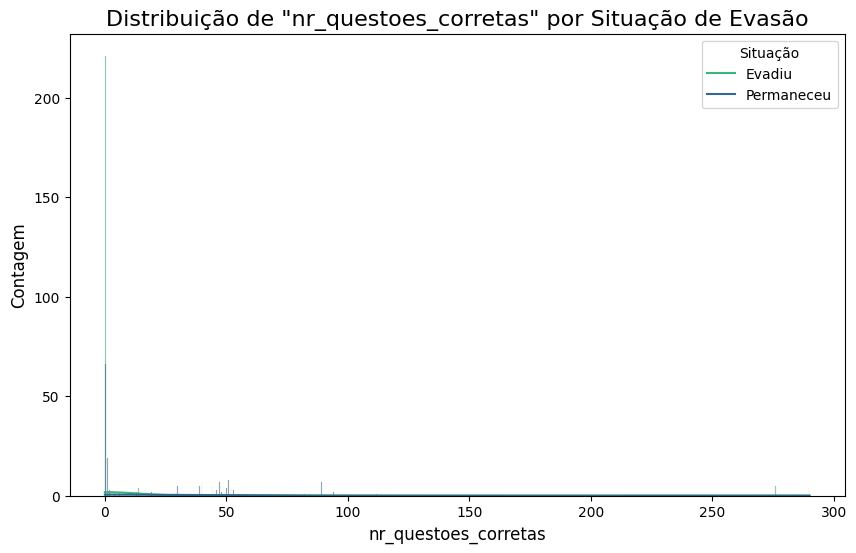

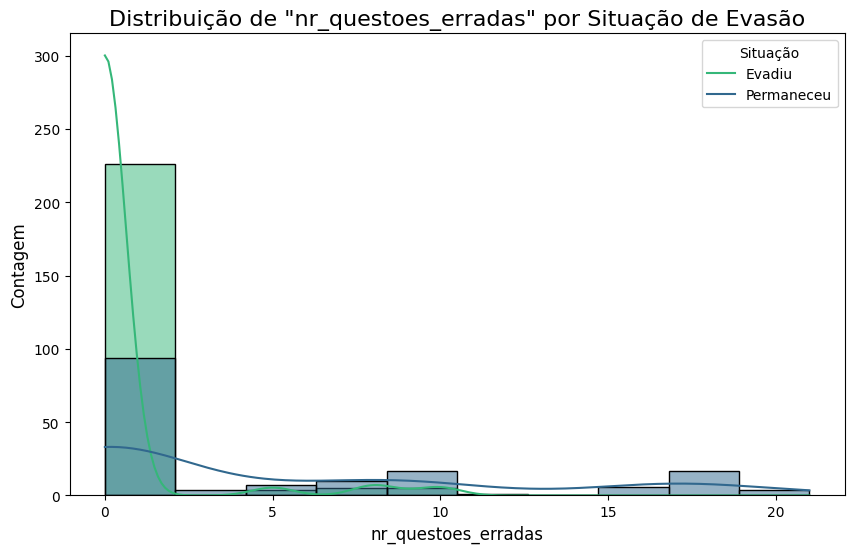

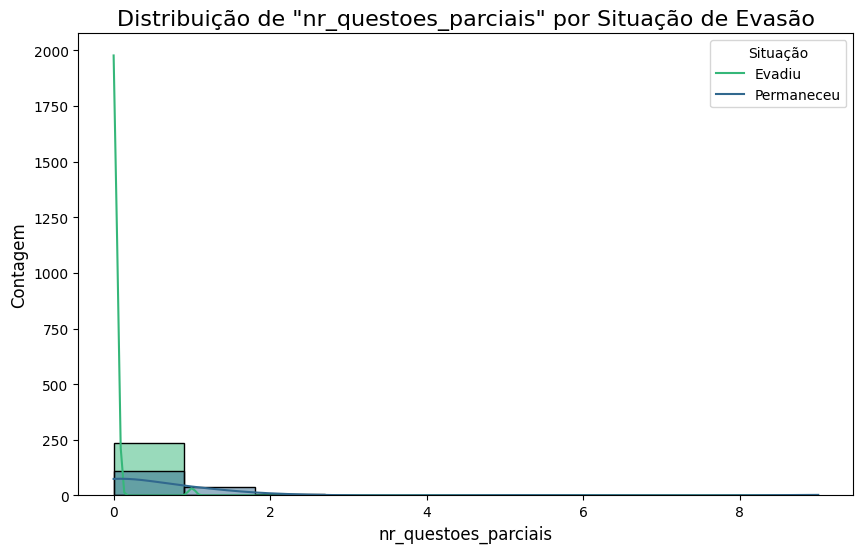

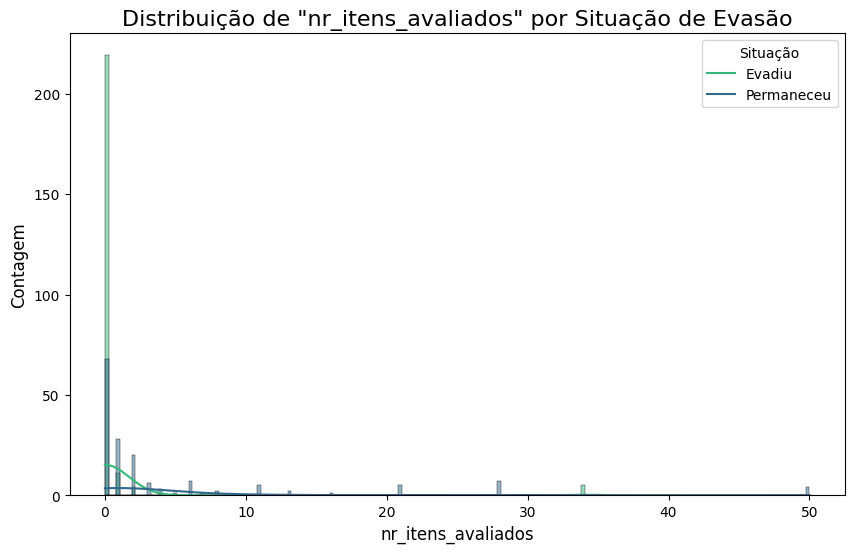

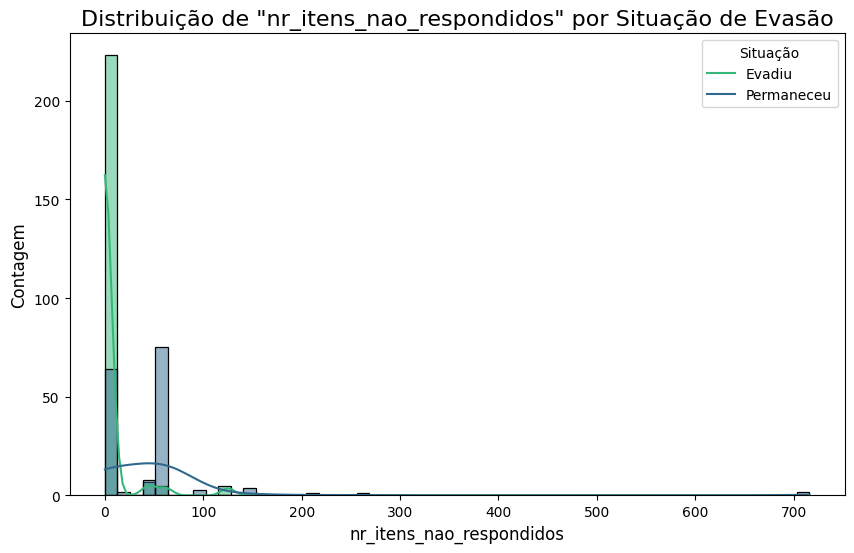

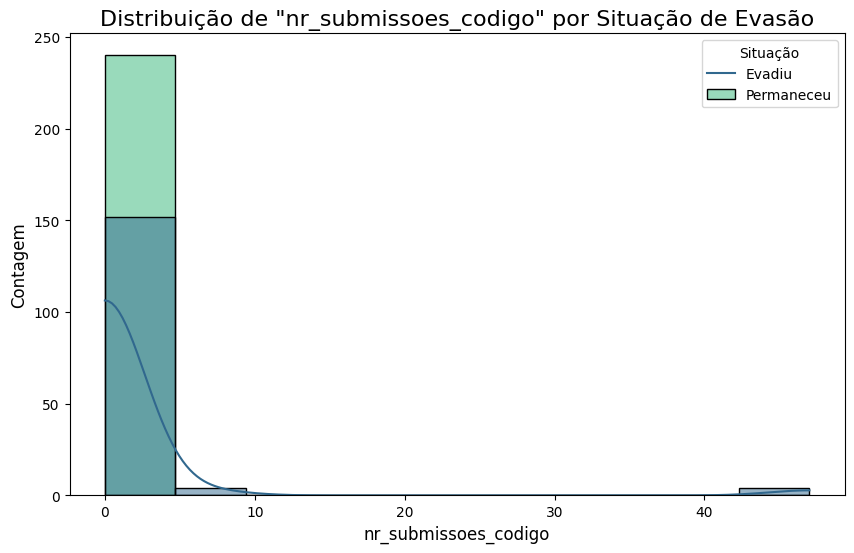



--- 5.3: Análise de Features Categóricas vs. Evasão ---


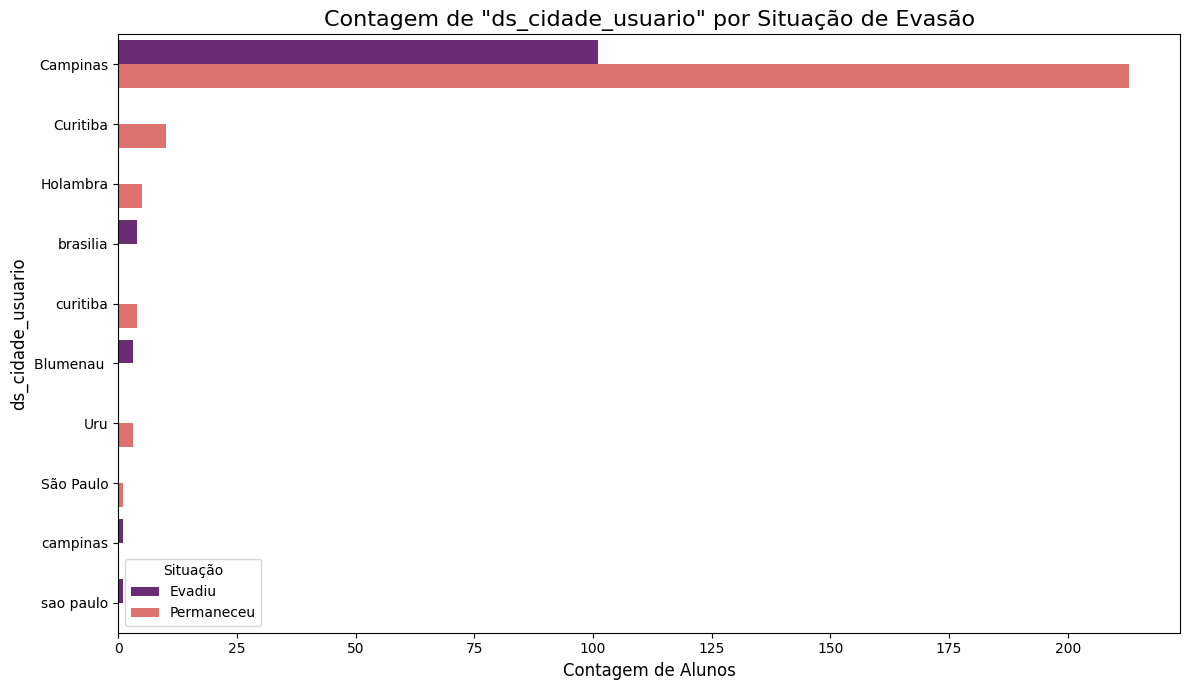



--- 5.4: Matriz de Correlação das Features Numéricas ---


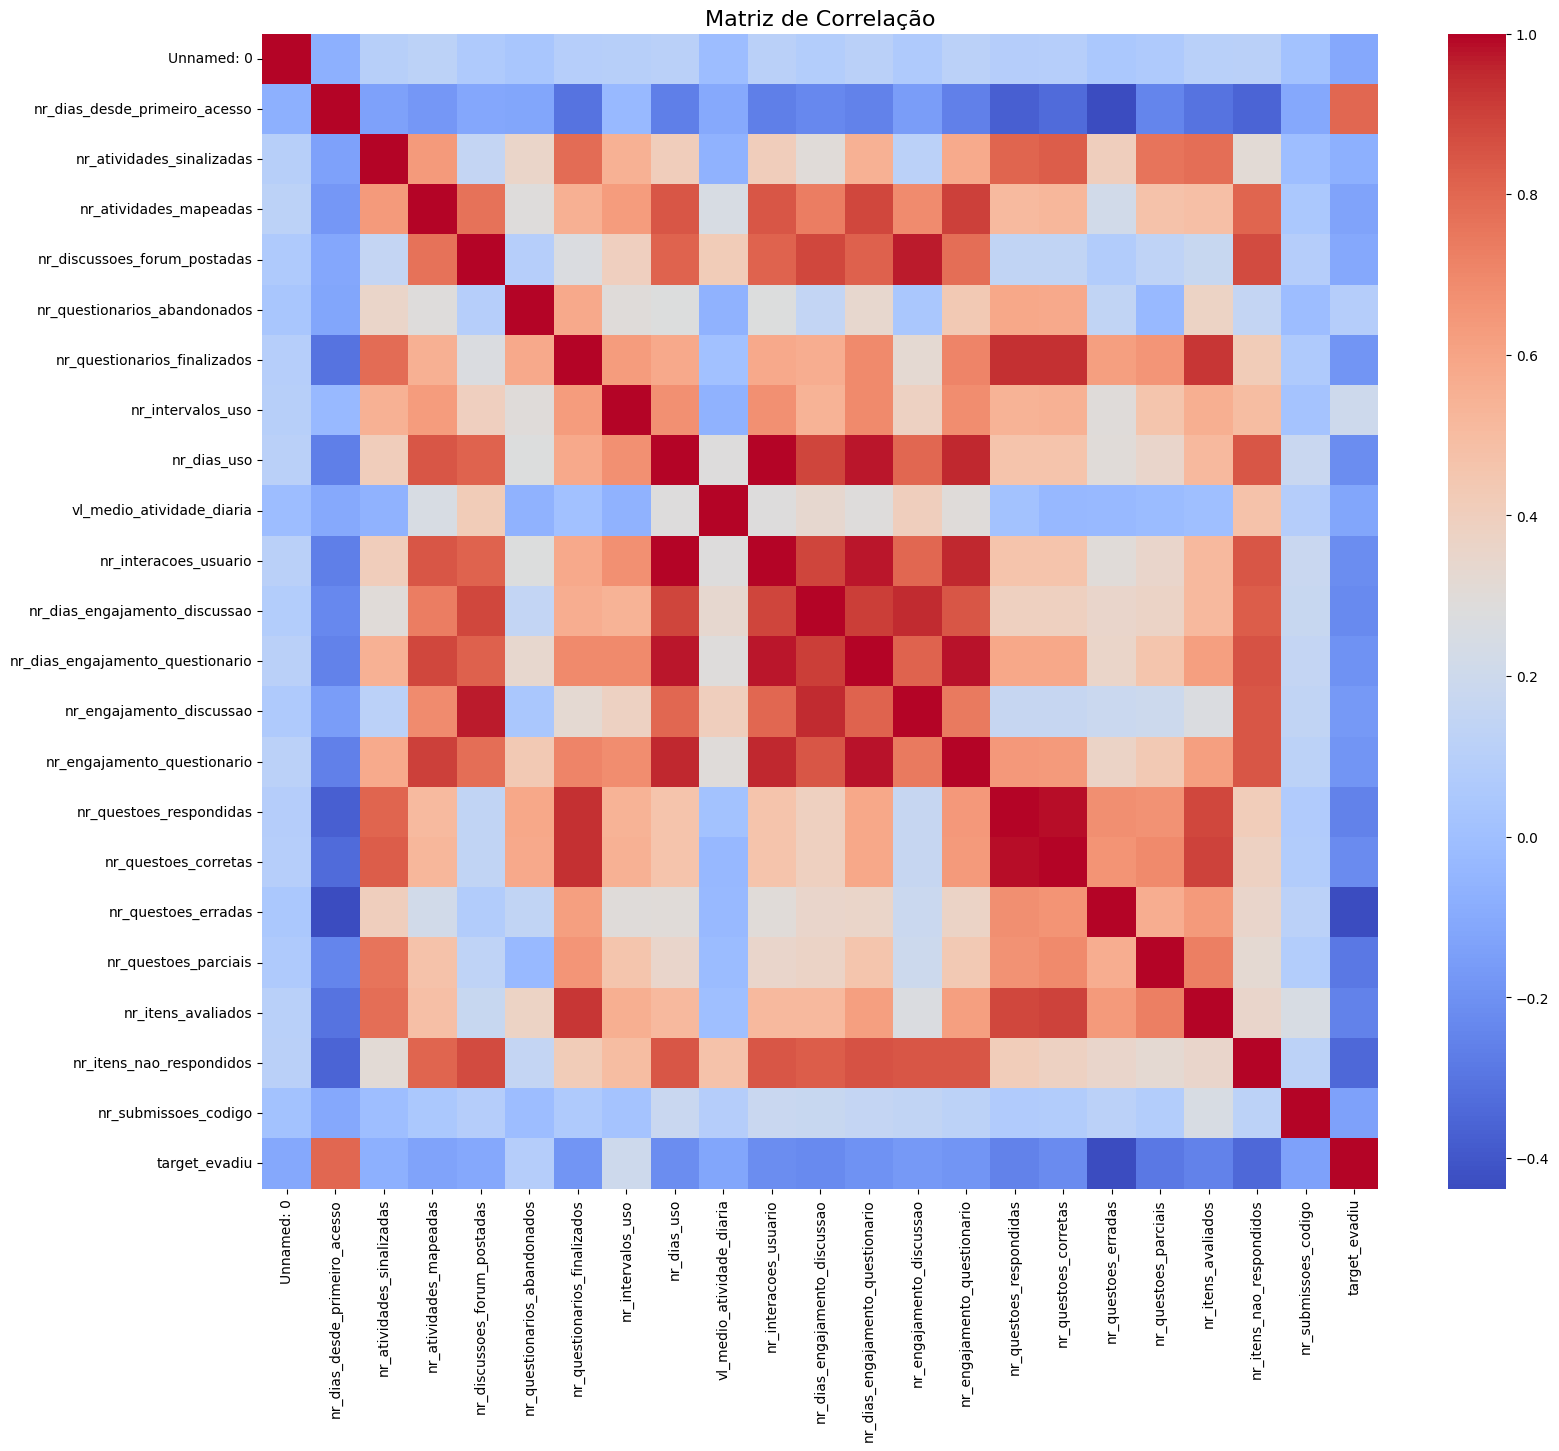


Correlação das features com a variável alvo ('target_evadiu'):
target_evadiu                       1.000000
nr_dias_desde_primeiro_acesso       0.798840
nr_intervalos_uso                   0.197446
nr_questionarios_abandonados        0.086425
nr_atividades_sinalizadas          -0.073431
Unnamed: 0                         -0.108877
nr_discussoes_forum_postadas       -0.109383
vl_medio_atividade_diaria          -0.121634
nr_atividades_mapeadas             -0.129255
nr_submissoes_codigo               -0.138977
nr_engajamento_discussao           -0.172848
nr_engajamento_questionario        -0.187551
nr_questionarios_finalizados       -0.189848
nr_dias_engajamento_questionario   -0.197330
nr_dias_uso                        -0.213602
nr_interacoes_usuario              -0.213602
nr_questoes_corretas               -0.221169
nr_dias_engajamento_discussao      -0.225877
nr_questoes_respondidas            -0.254910
nr_itens_avaliados                 -0.255667
nr_questoes_parciais               -

In [10]:
# Bloco 5: Análise Exploratória das Features

print("--- Bloco 5: Iniciando a Análise Exploratória das Features Limpas ---")

if 'df_treino_final' in locals():
    
    # --- 5.1: Separar colunas por tipo ---
    # Identificar a nossa variável alvo
    target = 'target_evadiu'
    
    # Identificar as colunas de features (todas exceto o alvo)
    features = df_treino_final.drop(columns=[target]).columns
    
    # Separar features em numéricas e categóricas
    numerical_features = df_treino_final[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df_treino_final[features].select_dtypes(include=['object']).columns.tolist()
    
    print(f"Encontramos {len(numerical_features)} features numéricas e {len(categorical_features)} features categóricas.")
    print("\n" + "="*80)

    # --- 5.2: Análise das Features Numéricas ---
    print("\n--- 5.2: Análise de Features Numéricas vs. Evasão ---")
    
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        # Usando o parâmetro 'hue' para separar o gráfico pela variável alvo
        sns.histplot(data=df_treino_final, x=feature, hue=target, kde=True, palette='viridis')
        plt.title(f'Distribuição de "{feature}" por Situação de Evasão', fontsize=16)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Contagem', fontsize=12)
        plt.legend(title='Situação', labels=['Evadiu', 'Permaneceu'])
        plt.show()

    # --- 5.3: Análise das Features Categóricas ---
    print("\n" + "="*80)
    print("\n--- 5.3: Análise de Features Categóricas vs. Evasão ---")

    for feature in categorical_features:
        plt.figure(figsize=(12, 7))
        sns.countplot(data=df_treino_final, y=feature, hue=target, palette='magma', order=df_treino_final[feature].value_counts().index)
        plt.title(f'Contagem de "{feature}" por Situação de Evasão', fontsize=16)
        plt.xlabel('Contagem de Alunos', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.legend(title='Situação', labels=['Evadiu', 'Permaneceu'])
        plt.tight_layout()
        plt.show()
        
    # --- 5.4: Matriz de Correlação ---
    print("\n" + "="*80)
    print("\n--- 5.4: Matriz de Correlação das Features Numéricas ---")
    
    plt.figure(figsize=(18, 15))
    # Incluindo o alvo na matriz de correlação para ver a relação das features com ele
    correlation_matrix = df_treino_final[numerical_features + [target]].corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm') # annot=False para não poluir
    plt.title('Matriz de Correlação', fontsize=16)
    plt.show()
    
    print("\nCorrelação das features com a variável alvo ('target_evadiu'):")
    # Exibindo apenas a correlação com o alvo, ordenada
    print(correlation_matrix[target].sort_values(ascending=False))
    
else:
    print("ERRO: DataFrame 'df_treino_final' não foi encontrado.")

In [11]:
# Bloco 6: Tratamento Final de Features e Dados Faltantes Restantes

print("--- Bloco 6: Iniciando a Limpeza Final ---")

if 'df_treino_final' in locals():
    
    # --- 6.1: Remover a coluna 'Unnamed: 0' ---
    coluna_para_remover = 'Unnamed: 0'
    
    # Verificar se a coluna existe antes de tentar removê-la
    if coluna_para_remover in df_treino_final.columns:
        df_treino_final = df_treino_final.drop(columns=[coluna_para_remover])
        df_teste_final = df_teste_final.drop(columns=[coluna_para_remover])
        print(f"✅ Coluna '{coluna_para_remover}' removida com sucesso.")
    else:
        print(f"✅ Coluna '{coluna_para_remover}' não encontrada. Nenhuma ação necessária.")

        
    # --- 6.2: Preencher dados faltantes restantes (imputação) ---
    # Para colunas categóricas, preencher com uma string como 'Desconhecida' é uma ótima estratégia
    colunas_categoricas_restantes = df_treino_final.select_dtypes(include=['object']).columns

    for col in colunas_categoricas_restantes:
        # Usamos .fillna() para preencher os valores nulos (NaN)
        df_treino_final[col] = df_treino_final[col].fillna('Desconhecida')
        df_teste_final[col] = df_teste_final[col].fillna('Desconhecida')
    
    print("✅ Dados faltantes das colunas categóricas preenchidos com 'Desconhecida'.")
    
    # --- Verificação Final ---
    print("\n--- Verificação Final de Dados Faltantes ---")
    if df_treino_final.isnull().sum().sum() == 0:
        print("✅ Perfeito! Não há mais nenhum dado faltante no conjunto de treino.")
    else:
        print("Ainda existem dados faltantes:")
        print(df_treino_final.isnull().sum())
        
    print(f"\nFormato final e pronto para modelagem: {df_treino_final.shape}")

else:
    print("ERRO: DataFrame 'df_treino_final' não foi encontrado.")

--- Bloco 6: Iniciando a Limpeza Final ---
✅ Coluna 'Unnamed: 0' removida com sucesso.
✅ Dados faltantes das colunas categóricas preenchidos com 'Desconhecida'.

--- Verificação Final de Dados Faltantes ---
Ainda existem dados faltantes:
ds_cidade_usuario                     0
nr_dias_desde_primeiro_acesso         0
nr_atividades_sinalizadas             0
nr_atividades_mapeadas                0
nr_discussoes_forum_postadas          0
nr_questionarios_abandonados          0
nr_questionarios_finalizados          0
nr_intervalos_uso                   191
nr_dias_uso                           0
vl_medio_atividade_diaria           191
nr_interacoes_usuario                 0
nr_dias_engajamento_discussao         0
nr_dias_engajamento_questionario      0
nr_engajamento_discussao              0
nr_engajamento_questionario           0
nr_questoes_respondidas               0
nr_questoes_corretas                  0
nr_questoes_erradas                   0
nr_questoes_parciais                  0
nr

In [12]:
# Bloco 7: Pré-processamento e Treinamento (Versão 2 - Corrigida com Imputer)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer  # <<<--- IMPORTANTE: Importar o SimpleImputer

# Importando os modelos que vamos treinar
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("--- Bloco 7 (V2): Iniciando o Pré-processamento e Treinamento ---")

if 'df_treino_final' in locals():
    # --- 7.1: Separar Features (X) e Alvo (y) ---
    X = df_treino_final.drop(columns=['target_evadiu'])
    y = df_treino_final['target_evadiu']

    # --- 7.2: Dividir os dados em Treino e Validação ---
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_val)} de validação.")

    # --- 7.3: Criar o Pipeline de Pré-processamento (COM CORREÇÃO) ---
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object']).columns

    # ***** INÍCIO DA CORREÇÃO *****
    # Criar o transformador para dados numéricos
    # Adicionamos o SimpleImputer para preencher valores ausentes com a mediana
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    # ***** FIM DA CORREÇÃO *****

    # Criar o transformador para dados categóricos
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Unir os dois transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    print("\n✅ Pipeline de pré-processamento (com imputer) criado.")

    # --- 7.4: Treinar Modelos de Baseline ---
    
    # Modelo 1: Regressão Logística
    print("Treinando o modelo de Regressão Logística...")
    pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(random_state=42))])
    pipeline_lr.fit(X_train, y_train)
    print("✅ Modelo de Regressão Logística treinado.")

    # Modelo 2: Random Forest
    print("\nTreinando o modelo Random Forest...")
    pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', RandomForestClassifier(random_state=42))])
    pipeline_rf.fit(X_train, y_train)
    print("✅ Modelo Random Forest treinado.")
    
    print("\n--- Modelos de baseline prontos para avaliação! ---")
    
else:
    print("ERRO: DataFrame 'df_treino_final' não foi encontrado.")

--- Bloco 7 (V2): Iniciando o Pré-processamento e Treinamento ---
Dados divididos em 320 amostras de treino e 80 de validação.

✅ Pipeline de pré-processamento (com imputer) criado.
Treinando o modelo de Regressão Logística...
✅ Modelo de Regressão Logística treinado.

Treinando o modelo Random Forest...
✅ Modelo Random Forest treinado.

--- Modelos de baseline prontos para avaliação! ---


--- Bloco 8: Avaliando o Desempenho dos Modelos ---

--- Avaliação do Modelo: Regressão Logística ---
Acurácia: 0.9375
Precisão: 0.9778
Recall: 0.9167
F1-Score: 0.9462
AUC-ROC: 0.9707


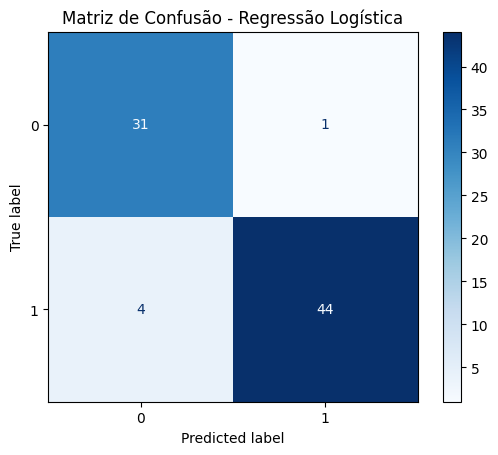


--- Avaliação do Modelo: Random Forest ---
Acurácia: 0.9875
Precisão: 0.9796
Recall: 1.0000
F1-Score: 0.9897
AUC-ROC: 1.0000


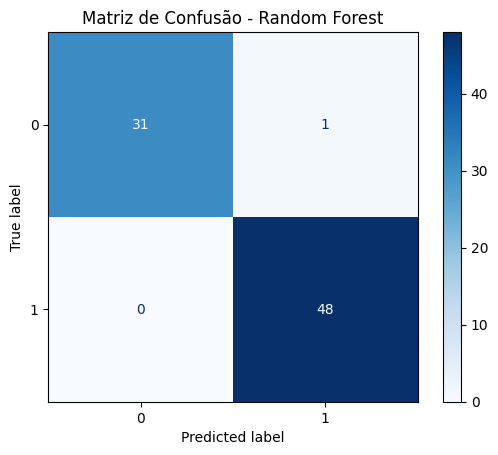


--- Comparativo com a Curva ROC ---


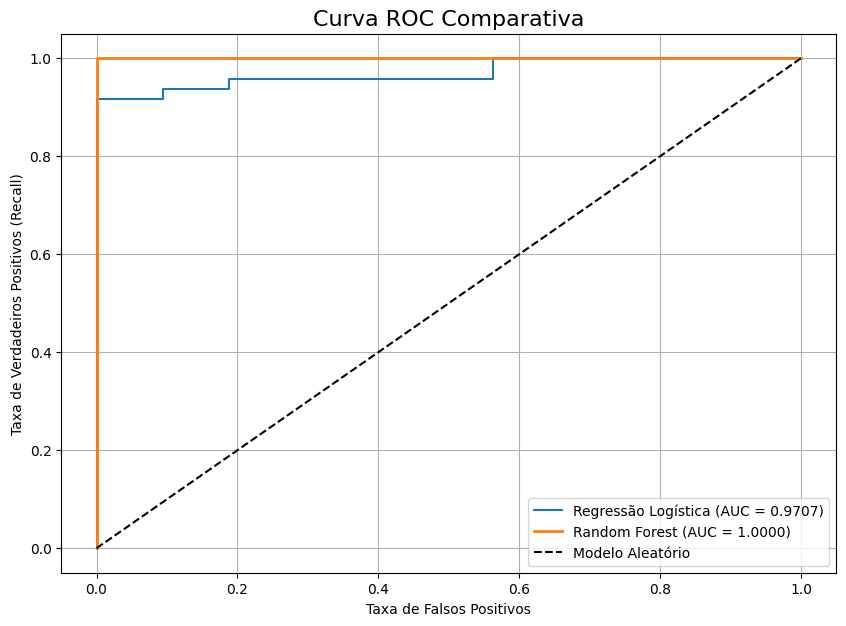

In [13]:
# Bloco 8: Avaliação dos Modelos na Validação

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve)

print("--- Bloco 8: Avaliando o Desempenho dos Modelos ---")

if 'pipeline_lr' in locals() and 'pipeline_rf' in locals():
    # --- 8.1: Fazer previsões no conjunto de validação ---
    y_pred_lr = pipeline_lr.predict(X_val)
    y_proba_lr = pipeline_lr.predict_proba(X_val)[:, 1] # Probabilidades para a classe positiva (1)

    y_pred_rf = pipeline_rf.predict(X_val)
    y_proba_rf = pipeline_rf.predict_proba(X_val)[:, 1]

    # --- 8.2: Função para avaliar e mostrar os resultados ---
    def avaliar_modelo(y_real, y_pred, y_proba, nome_modelo):
        print(f"\n--- Avaliação do Modelo: {nome_modelo} ---")
        
        # Calcular métricas
        acc = accuracy_score(y_real, y_pred)
        precision = precision_score(y_real, y_pred)
        recall = recall_score(y_real, y_pred)
        f1 = f1_score(y_real, y_pred)
        auc = roc_auc_score(y_real, y_proba)
        
        print(f"Acurácia: {acc:.4f}")
        print(f"Precisão: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc:.4f}")
        
        # Plotar Matriz de Confusão
        cm = confusion_matrix(y_real, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Matriz de Confusão - {nome_modelo}')
        plt.show()

    # Avaliar ambos os modelos
    avaliar_modelo(y_val, y_pred_lr, y_proba_lr, 'Regressão Logística')
    avaliar_modelo(y_val, y_pred_rf, y_proba_rf, 'Random Forest')

    # --- 8.3: Plotar Curva ROC comparativa ---
    print("\n" + "="*80)
    print("--- Comparativo com a Curva ROC ---")
    
    fpr_lr, tpr_lr, _ = roc_curve(y_val, y_proba_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)
    
    plt.figure(figsize=(10, 7))
    plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {roc_auc_score(y_val, y_proba_lr):.4f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_val, y_proba_rf):.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatório') # Linha de referência
    
    plt.title('Curva ROC Comparativa', fontsize=16)
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
    plt.legend()
    plt.grid()
    plt.show()

else:
    print("ERRO: Os modelos não foram treinados. Execute o Bloco 7 primeiro.")

--- Bloco 9: Treinando e Avaliando a Rede Neural ---
✅ Dados pré-processados para a Rede Neural.

Arquitetura da Rede Neural:


c:\Users\Marcos\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)


Treinando a Rede Neural...
✅ Rede Neural treinada com sucesso.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

--- Avaliação do Modelo: Rede Neural (Keras) ---
Acurácia: 0.9375
Precisão: 0.9778
Recall: 0.9167
F1-Score: 0.9462
AUC-ROC: 0.9948


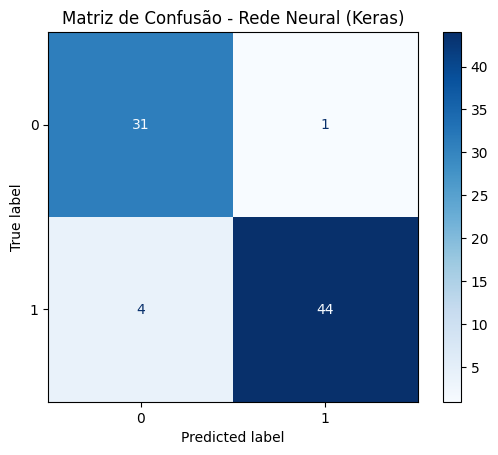

In [14]:
# Bloco 9: Treinamento e Avaliação da Rede Neural (Keras)

# Imports necessários para o TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Garantir que os resultados sejam reprodutíveis
tf.random.set_seed(42)

print("--- Bloco 9: Treinando e Avaliando a Rede Neural ---")

if 'preprocessor' in locals():
    # --- 9.1: Pré-processar os dados para a Rede Neural ---
    # As redes neurais recebem os dados já transformados (sem o pipeline completo)
    # Usamos o preprocessor que já foi 'treinado' no Bloco 7
    X_train_proc = preprocessor.transform(X_train)
    X_val_proc = preprocessor.transform(X_val)

    print("✅ Dados pré-processados para a Rede Neural.")

    # --- 9.2: Construir a arquitetura do modelo ---
    # input_dim será o número de features após o pré-processamento (OneHotEncoding expande as colunas)
    input_dim = X_train_proc.shape[1]

    model_nn = Sequential([
        # Camada de entrada com 32 neurônios. input_dim define o número de features de entrada.
        Dense(32, activation='relu', input_dim=input_dim),
        # Dropout é uma técnica de regularização para evitar overfitting, 'desligando' 20% dos neurônios aleatoriamente durante o treino
        Dropout(0.2),
        # Uma segunda camada escondida com 16 neurônios
        Dense(16, activation='relu'),
        # Camada de saída com 1 neurônio e ativação 'sigmoid', ideal para classificação binária (retorna uma probabilidade entre 0 e 1)
        Dense(1, activation='sigmoid')
    ])

    # Compilar o modelo, definindo o otimizador, a função de perda e as métricas
    model_nn.compile(optimizer='adam', 
                   loss='binary_crossentropy', 
                   metrics=['AUC', 'Precision', 'Recall'])
    
    print("\nArquitetura da Rede Neural:")
    model_nn.summary()

    # --- 9.3: Treinar a Rede Neural ---
    print("\nTreinando a Rede Neural...")
    # O treinamento é feito aqui. verbose=0 para manter a saída limpa.
    history = model_nn.fit(X_train_proc, y_train, 
                           validation_data=(X_val_proc, y_val),
                           epochs=50,         # Número de vezes que o modelo verá o dataset completo
                           batch_size=16,     # Número de amostras por atualização do gradiente
                           verbose=0)         # Não mostrar o log de cada época
    
    print("✅ Rede Neural treinada com sucesso.")

    # --- 9.4: Avaliar a Rede Neural ---
    # Fazer previsões
    y_proba_nn = model_nn.predict(X_val_proc).flatten() # Achatamos para ter um array 1D
    y_pred_nn = (y_proba_nn > 0.5).astype(int) # Convertendo probabilidades em classes (0 ou 1)

    # Usar a mesma função de avaliação do bloco anterior
    avaliar_modelo(y_val, y_pred_nn, y_proba_nn, 'Rede Neural (Keras)')

else:
    print("ERRO: O pré-processador não foi definido. Execute o Bloco 7 primeiro.")

--- Bloco 10: Avaliando o Modelo Campeão no Conjunto de Teste Final ---

--- Avaliação do Modelo: Random Forest (Teste Final) ---
Acurácia: 0.9900
Precisão: 1.0000
Recall: 0.9853
F1-Score: 0.9926
AUC-ROC: 0.9991


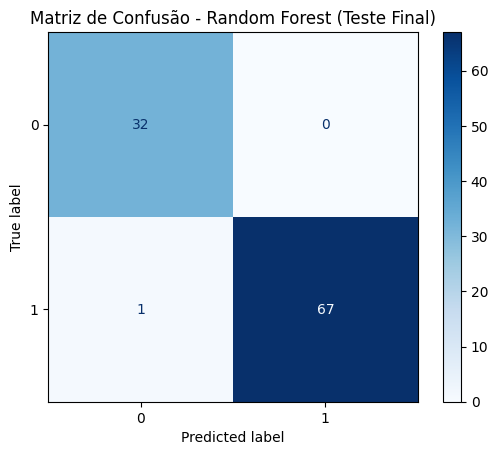

In [15]:
# Bloco 10: Teste Final do Modelo Campeão (Random Forest)

print("--- Bloco 10: Avaliando o Modelo Campeão no Conjunto de Teste Final ---")

if 'pipeline_rf' in locals() and 'df_teste_final' in locals():
    # --- 10.1: Separar Features (X) e Alvo (y) do conjunto de TESTE ---
    X_teste = df_teste_final.drop(columns=['target_evadiu'])
    y_teste = df_teste_final['target_evadiu']

    # --- 10.2: Fazer previsões no conjunto de teste ---
    # Usamos o pipeline_rf que já foi treinado no Bloco 7
    y_pred_teste_rf = pipeline_rf.predict(X_teste)
    y_proba_teste_rf = pipeline_rf.predict_proba(X_teste)[:, 1]

    # --- 10.3: Avaliar o desempenho final ---
    # Reutilizamos a nossa função de avaliação com os dados de teste
    avaliar_modelo(y_teste, y_pred_teste_rf, y_proba_teste_rf, 'Random Forest (Teste Final)')

else:
    print("ERRO: O pipeline do Random Forest ou o df_teste_final não foram encontrados.")


--- Bloco 11: Explicabilidade do Modelo com SHAP (Versão Final) ---
Calculando os valores SHAP...
Valores SHAP calculados.

Gerando o gráfico de resumo SHAP...


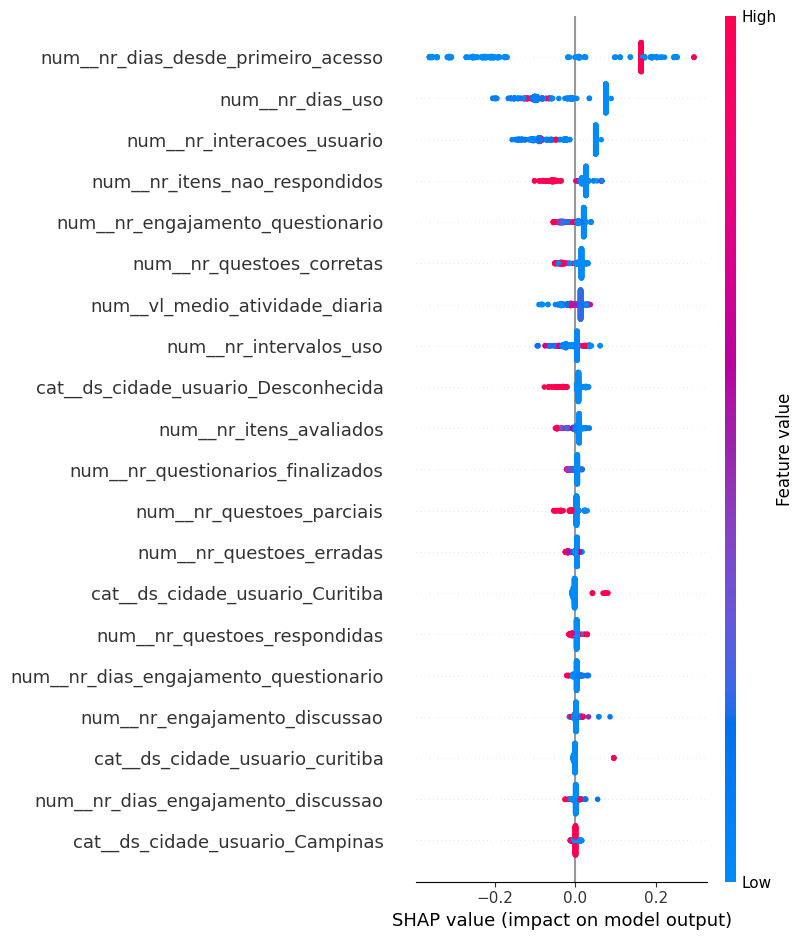

In [18]:
# Bloco 11: Explicabilidade do Modelo com SHAP (Versão Final Corrigida)


import shap

print("\n--- Bloco 11: Explicabilidade do Modelo com SHAP (Versão Final) ---")

if 'pipeline_rf' in locals():
    # --- 11.1: Extrair os componentes do pipeline ---
    preprocessor_final = pipeline_rf.named_steps['preprocessor']
    model_rf_final = pipeline_rf.named_steps['classifier']

    # --- 11.2: Aplicar o pré-processamento nos dados de treino ---
    X_train_proc = preprocessor_final.transform(X_train)
    feature_names = preprocessor_final.get_feature_names_out()
    X_train_proc_df = pd.DataFrame(X_train_proc, columns=feature_names)

    # --- 11.3: Calcular os valores SHAP ---
    print("Calculando os valores SHAP...")
    explainer = shap.TreeExplainer(model_rf_final)
    shap_values = explainer.shap_values(X_train_proc_df)
    print("Valores SHAP calculados.")
    
    # ***** INÍCIO DA CORREÇÃO *****
    # Com base na nossa depuração, sabemos que shap_values é um array (samples, features, classes)
    # Vamos fatiar para pegar apenas os valores da classe positiva (Evadiu = 1)
    shap_values_classe_1 = shap_values[:, :, 1]
    # ***** FIM DA CORREÇÃO *****

    # --- 11.4: Gerar o gráfico de resumo SHAP ---
    print("\nGerando o gráfico de resumo SHAP...")
    # Agora o plot deve funcionar, pois os formatos são compatíveis
    shap.summary_plot(shap_values_classe_1, X_train_proc_df)

else:
    print("ERRO: O pipeline do Random Forest não foi encontrado.")